In [1]:
!pip install aif360
!pip install 'aif360[Reductions]'
%matplotlib inline
# Load all necessary packages
from sklearn.naive_bayes import GaussianNB
import sys
sys.path.append("../")
import numpy as np
from collections import OrderedDict
import shutil
import seaborn as sns
from sklearn.svm import SVC, LinearSVC
from tqdm import tqdm
from warnings import warn
import pandas as pd
import operator

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.postprocessing.reject_option_classification import RejectOptionClassification

import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatSlider

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 214 kB 4.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 4.4 MB/s 


pip install 'aif360[LawSchoolGPA]'


In [2]:
import shutil

original = r'/content/compas-scores-two-years.csv'
target = r'/usr/local/lib/python3.8/dist-packages/aif360/data/raw/compas'
shutil.copy(original,target)

'/usr/local/lib/python3.8/dist-packages/aif360/data/raw/compas/compas-scores-two-years.csv'

In [3]:
def compute_metrics(dataset_true, dataset_pred, non_privileged, privileged, disp = True):
    pred_classification_metric = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=non_privileged,
                                                 privileged_groups=privileged)
    metrics_dict = OrderedDict()
    metrics_dict["Balanced accuracy"] = (pred_classification_metric.true_positive_rate()+pred_classification_metric.true_negative_rate())/2
    metrics_dict["Statistical parity difference"] = pred_classification_metric.statistical_parity_difference()
    metrics_dict["Disparate impact"] = pred_classification_metric.disparate_impact()
    metrics_dict["Average odds difference"] = pred_classification_metric.average_odds_difference()
    metrics_dict["Equal opportunity difference"] = pred_classification_metric.equal_opportunity_difference()
    metrics_dict["Theil index"] = pred_classification_metric.theil_index()

    if disp == True:
        for key, value in metrics_dict.items():
            print(str(key) +" = "+ str(value))

    return metrics_dict

#### Load dataset and specify options

In [4]:
def load_preproc_data_compas_data(protected_attributes):
    def preprocessing(df):
        df = df[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text','sex', 'priors_count', 'days_b_screening_arrest', 'decile_score','is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
        
        features = ['two_year_recid','sex', 'race','age_cat', 'priors_count', 'c_charge_degree']

        def quantizeLOS(x):
            if x<= 7:
                return '<week'
            if 8<x<=93:
                return '<3months'
            else:
                return '>3 months'

        def quantizePrior(x):
            if x <=0:
                return '0'
            elif 1<=x<=3:
                return '1 to 3'
            else:
                return 'More than 3'

        def quantizeScore(x):
            if (x == 'High')| (x == 'Medium'):
                return 'MediumHigh'
            else:
                return x

        def group_race(x):
            if x == "Caucasian":
                return 1.0
            else:
                return 0.0

        def adjustAge(x):
            if x == '25 - 45':
                return '25 to 45'
            else:
                return x

        indx = df['days_b_screening_arrest'] <= 30
        indx = (df['is_recid'] != -1) & indx
        indx = (df['days_b_screening_arrest'] >= -30) & indx
        indx = (df['score_text'] != 'N/A') & indx
        indx = (df['c_charge_degree'] != "O") & indx
        
        df = df.loc[indx,:]
        df['length_of_stay'] = (pd.to_datetime(df['c_jail_out'])- pd.to_datetime(df['c_jail_in'])) / np.timedelta64(1, 'D')
        
        df_filter = df.loc[~df['race'].isin(['Native American','Hispanic','Asian','Other']),:]

        df_filter_fields = df_filter[['sex','race','age_cat','c_charge_degree','score_text','priors_count','is_recid','two_year_recid','length_of_stay']].copy()

        df_filter_fields['priors_count'] = df_filter_fields['priors_count'].apply(lambda x: quantizePrior(x))
        df_filter_fields['length_of_stay'] = df_filter_fields['length_of_stay'].apply(lambda x: quantizeLOS(x))
        df_filter_fields['score_text'] = df_filter_fields['score_text'].apply(lambda x: quantizeScore(x))
        df_filter_fields['age_cat'] = df_filter_fields['age_cat'].apply(lambda x: adjustAge(x))

        df_filter_fields['sex'] = df_filter_fields['sex'].replace({'Female': 1.0, 'Male': 0.0})
        df_filter_fields['race'] = df_filter_fields['race'].apply(lambda x: group_race(x))
        df = df_filter_fields[features]
        return df

    list_features = ['age_cat', 'c_charge_degree', 'priors_count', 'sex', 'race']
    D_features = [protected_attributes]  if protected_attributes is None else protected_attributes
    Y_features = ['two_year_recid']
    X_features = list(set(list_features)-set(D_features))
    category_features = ['age_cat', 'priors_count', 'c_charge_degree']

    all_privileged_classes = {"sex": [1.0],
                              "race": [1.0]}

    all_bias_maps = {"sex": {0.0: 'Male', 1.0: 'Female'},
                                    "race": {1.0: 'Caucasian', 0.0: 'Not Caucasian'}}


    return CompasDataset(
        label_name=Y_features[0],
        favorable_classes=[0],
        protected_attribute_names=D_features,
        privileged_classes=[all_privileged_classes[x] for x in D_features],
        instance_weights_name=None,
        categorical_features=category_features,
        features_to_keep=X_features+Y_features+D_features,
        na_values=[],
        metadata={'label_maps': [{1.0: 'Did recid.', 0.0: 'No recid.'}],
                  'protected_attribute_maps': [all_bias_maps[x]
                                for x in D_features]},
        custom_preprocessing=preprocessing)


In [5]:

bias_toggle = 0 
if bias_toggle == 1:
    privileged_groups = [{'sex': 1}]
    unprivileged_groups = [{'sex': 0}]
    dataset_orig = load_preproc_data_compas(['sex'])
else:
    privileged_groups = [{'race': 1}]
    unprivileged_groups = [{'race': 0}]  
    dataset_orig = load_preproc_data_compas_data(['race'])

np.random.seed(1)

#### Split into train, test and validation

In [6]:
orig_train_set, orig_valid_set = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = orig_valid_set.split([0.5], shuffle=True)

#### Clean up training data and display properties of the data

In [7]:
# print out some labels, names, etc.
print("Training Dataset shape: ", orig_train_set.features.shape  )
print("Favorable and unfavorable labels: ",orig_train_set.favorable_label, orig_train_set.unfavorable_label)
print("Protected attribute names: ", orig_train_set.protected_attribute_names)
print("Dataset feature names:", orig_train_set.feature_names)

Training Dataset shape:  (3694, 10)
Favorable and unfavorable labels:  0.0 1.0
Protected attribute names:  ['race']
Dataset feature names: ['sex', 'race', 'age_cat=25 to 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'priors_count=0', 'priors_count=1 to 3', 'priors_count=More than 3', 'c_charge_degree=F', 'c_charge_degree=M']


#### Metric for original training data

In [8]:
metric_orig_train = BinaryLabelDatasetMetric(orig_train_set, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
print("Original training dataset....")
print("Difference in mean outcomes between unprivileged and privileged groups = ", float(round(metric_orig_train.mean_difference(),4)))

Original training dataset....
Difference in mean outcomes between unprivileged and privileged groups =  -0.1271


### Train classifier on original data

In [9]:
# Logistic regression classifier and predictions
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier

def scaling(ds):
    orig_scaling = StandardScaler()
    x = orig_scaling.fit_transform(ds.features)
    y = ds.labels.ravel()
    return orig_scaling, x, y

def Linear_SVC (a,b):
    linear_svc = LinearSVC(dual=False)  # dual=False when n_samples > n_features.
    clf = linear_svc.fit(a, b)
    calibrator = CalibratedClassifierCV(clf, cv='prefit')
    model=calibrator.fit(a,b)
    return model

def RandomForest(a, b, c):
    clf = RandomForestClassifier()
    clf.fit(a, b, sample_weight=c.instance_weights)
    return clf

def NaiveBayes(a, b):
    classifier = GaussianNB()
    classifier.fit(a, b)
    return classifier

orig_scaling, X_train, y_train = scaling(orig_train_set)
classifier_used = NaiveBayes(X_train, y_train)
y_train_pred = round(classifier_used.score(X_train, y_train) * 100, 2)

#### Obtain scores for validation and test sets

In [10]:
filter = (classifier_used.classes_ == orig_train_set.favorable_label)
pos_index = np.where(filter)[0][0]
orig_train_pred_data = orig_train_set.copy(deepcopy=True)
orig_train_pred_data.labels = y_train_pred

orig_valid_pred_data = dataset_orig_valid.copy(deepcopy=True)
X_valid = orig_scaling.transform(orig_valid_pred_data.features)
y_valid = orig_valid_pred_data.labels
orig_valid_pred_data.scores = classifier_used.predict_proba(X_valid)[:,pos_index].reshape(-1,1)

orig_test_pred_data = dataset_orig_test.copy(deepcopy=True)
X_test = orig_scaling.transform(orig_test_pred_data.features)
y_test = orig_test_pred_data.labels
orig_test_pred_data.scores = classifier_used.predict_proba(X_test)[:,pos_index].reshape(-1,1)

#### Best threshold for classification only (no fairness)

In [11]:
threshold_count = 100
acc_bal = []
class_thresh_array = np.linspace(0.01, 0.99, threshold_count)

def threshold_classification(class_thresh_arr, dataset_orig_valid, valid_pred_dataset, unpvg, pvg, balanced_accuracy):
    for class_thresh in class_thresh_arr:
        valued_indices = valid_pred_dataset.scores > class_thresh
        valid_pred_dataset.labels[valued_indices] = valid_pred_dataset.favorable_label
        valid_pred_dataset.labels[~valued_indices] = valid_pred_dataset.unfavorable_label
        
        classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,valid_pred_dataset, 
                                                unprivileged_groups=unpvg,
                                                privileged_groups=pvg)
        avg_rates = (classified_metric_orig_valid.true_positive_rate()+classified_metric_orig_valid.true_negative_rate())/2
        balanced_accuracy.append(avg_rates)
    
    filtered = (balanced_accuracy == np.max(balanced_accuracy))
    y = class_thresh_arr[np.where(filtered)[0][0]]
    return y, balanced_accuracy

best_class_thresh, bal_acc = threshold_classification(class_thresh_array, dataset_orig_valid, orig_valid_pred_data, unprivileged_groups, privileged_groups, acc_bal)

print("Best balanced accuracy (no fairness constraints) = " , float(round(np.max(bal_acc),4)))
print("Optimal classification threshold (no fairness constraints) = ", float(round(best_class_thresh,4)))

Best balanced accuracy (no fairness constraints) =  0.6567
Optimal classification threshold (no fairness constraints) =  0.5049


#### Estimate optimal parameters for the ROC method

In [12]:
upper_bound = 0.05
lower_bound = -0.05
metric_name = "Statistical parity difference"

classifier_used_roc = RejectOptionClassification(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups,low_class_thresh=0.01, 
                                 high_class_thresh=0.99,num_class_thresh=100, num_ROC_margin=50,metric_name=metric_name, 
                                 metric_ub=upper_bound, metric_lb=lower_bound)
ROC = classifier_used_roc.fit(dataset_orig_valid, orig_valid_pred_data)

In [13]:
print("Optimal classification threshold (with fairness constraints) = ",float(round(ROC.classification_threshold,4)))
print("Optimal ROC margin = ", float(round(ROC.ROC_margin,4)))

Optimal classification threshold (with fairness constraints) =  0.6534
Optimal ROC margin =  0.1485


### Predictions from Validation Set

In [14]:
def plot_comparison_graphs(X,y):

    plt.subplot(1, 2, 1)
    lst = [X['Statistical parity difference'],y['Statistical parity difference'] ]
    plt.bar(['before','after'],lst , width=0.2)
    plt.ylim(-0.5,0.5)
    plt.title('Statistical parity difference')
    plt.subplot(1, 2, 2)
    lst=[X['Disparate impact'],y['Disparate impact'] ]
    plt.bar(['before','after'],lst , width=0.2)
    plt.title('Disparate impact')
    plt.ylim(-0.5,2)
    plt.show()

    plt.subplot(1, 2, 1)
    lst=[X['Average odds difference'],y['Average odds difference'] ]
    plt.bar(['before','after'],lst , width=0.2)
    plt.ylim(-0.5,0.5)
    plt.title('Average odds difference')
    plt.subplot(1, 2, 2)
    lst=[X['Equal opportunity difference'],y['Equal opportunity difference'] ]
    plt.bar(['before','after'],lst , width=0.2)
    plt.title('Equal opportunity difference')
    plt.ylim(-0.5,0.25)
    plt.show()

In [15]:
valued_indices = orig_valid_pred_data.scores > best_class_thresh
orig_valid_pred_data.labels[valued_indices] = orig_valid_pred_data.favorable_label
orig_valid_pred_data.labels[~valued_indices] = orig_valid_pred_data.unfavorable_label

print("Validation set")
print("Raw predictions - No fairness constraints, only maximizing balanced accuracy\n")

before_valid_metric = compute_metrics(dataset_orig_valid, orig_valid_pred_data, unprivileged_groups, privileged_groups)

Validation set
Raw predictions - No fairness constraints, only maximizing balanced accuracy

Balanced accuracy = 0.6566781477229238
Statistical parity difference = -0.30752047654504844
Disparate impact = 0.5542363734484619
Average odds difference = -0.2756372338779556
Equal opportunity difference = -0.27365321874751336
Theil index = 0.23117785242410177


In [16]:
transformed_valid_pred_data = ROC.predict(orig_valid_pred_data)

print("Validation set")
print("Transformed predictions - With fairness constraints \n")

after_valid_metric = compute_metrics(dataset_orig_valid, transformed_valid_pred_data, unprivileged_groups, privileged_groups)

Validation set
Transformed predictions - With fairness constraints 

Balanced accuracy = 0.6374282433983927
Statistical parity difference = -0.04802680565897249
Disparate impact = 0.8884083044982698
Average odds difference = -0.017741855265591217
Equal opportunity difference = -0.002466778069547204
Theil index = 0.3013289251374198


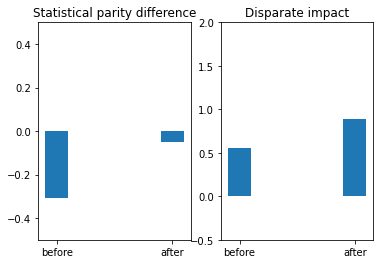

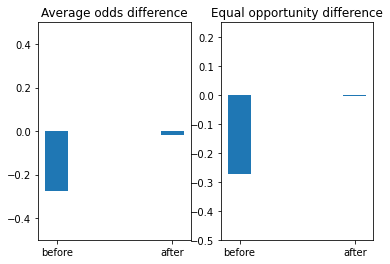

In [17]:
plot_comparison_graphs(before_valid_metric, after_valid_metric)

### Predictions from Test Set

In [18]:
valued_indices_test = orig_test_pred_data.scores > best_class_thresh
orig_test_pred_data.labels[valued_indices_test] = orig_test_pred_data.favorable_label
orig_test_pred_data.labels[~valued_indices_test] = orig_test_pred_data.unfavorable_label

print("Test set... Raw predictions - No fairness constraints, only maximizing balanced accuracy \n")

before_test_metric = compute_metrics(dataset_orig_test, orig_test_pred_data, unprivileged_groups, privileged_groups)

Test set... Raw predictions - No fairness constraints, only maximizing balanced accuracy 

Balanced accuracy = 0.6552928121831296
Statistical parity difference = -0.24830502296420504
Disparate impact = 0.6154888236622262
Average odds difference = -0.19944879945455676
Equal opportunity difference = -0.19799440298507465
Theil index = 0.2382366915836447


In [19]:
transformed_test_pred_data = ROC.predict(orig_test_pred_data)

print("Test set... Transformed predictions - With fairness constraints \n")

after_test_metric = compute_metrics(dataset_orig_test, transformed_test_pred_data, unprivileged_groups, privileged_groups)

Test set... Transformed predictions - With fairness constraints 

Balanced accuracy = 0.6394899462396448
Statistical parity difference = -0.03513887876357802
Disparate impact = 0.918773171553758
Average odds difference = 0.014954087684550865
Equal opportunity difference = 0.010338930348258724
Theil index = 0.29681192366605186


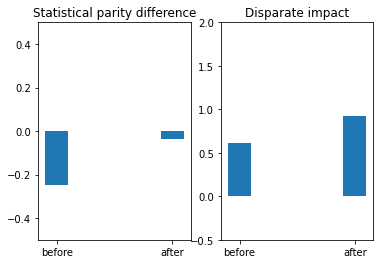

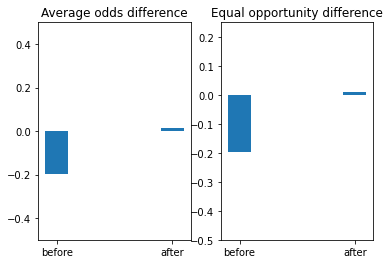

In [20]:
plot_comparison_graphs(before_test_metric, after_test_metric)